In [25]:
import os
import pickle

import pandas as pd
from tqdm import tqdm

import nibabel as nib
import numpy as np

from sklearn.model_selection import KFold
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from scipy.stats import pearsonr

import matplotlib.pyplot as plt
import seaborn as sns

In [26]:
def load_pickle(path):
    with open(path, 'rb') as f:
        pickled = pickle.load(f)
    return pickled
def save_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

In [27]:
## EDIT this before run

RESTART = False
model_selections = ['SocialGNN','LSTM', 'LSTM_Relation']
layer_selections = ['final_state', 'final_state', 'final_state']
rois = ['EVC', 'MT', 'EBA', 'LOC', 'pSTS', 'aSTS', 'FFA', 'PPA']
# rois = ['EVC', 'MT', 'EBA']
subject_ids = ['sub-01', 'sub-02', 'sub-03', 'sub-04']

# model_selections = ['SocialGNN']
# layer_selections = ['RNN_output']


In [28]:
neural_encoding_outputs_path = 'neural_encoding_outputs'
layer_representations_path = 'Data/layer_representations/'
TRAIN_IDX = load_pickle('Data/train_idx.pkl')

In [29]:
def load_roi_mask(roi_mask_path):
    """
    Load a 3D ROI mask using nibabel.
    
    Parameters:
    - roi_mask_path (str): Path to the 3D NIfTI mask file.
    
    Returns:
    - roi_mask (np.array): 3D binary mask indicating the ROI voxels.
    """
    mask_img = nib.load(roi_mask_path)
    roi_mask = mask_img.get_fdata().astype(bool)  # Convert to boolean mask
    return roi_mask

In [30]:
def apply_roi_mask(beta_values, roi_mask):
    """
    Apply the ROI mask to the 4D beta values.
    
    Parameters:
    - beta_values (np.array): 4D array of beta values (n_voxels_x, n_voxels_y, n_voxels_z, n_stimuli)
    - roi_mask (np.array): 3D binary mask indicating the ROI voxels
    
    Returns:
    - beta_values_roi (np.array): 2D array of beta values for the ROI, shape (n_stimuli, n_voxels_in_roi)
    """
    masked_beta_values = beta_values[roi_mask]  # Extract voxels inside the ROI
    n_stimuli = beta_values.shape[-1]
    beta_values_roi = masked_beta_values.reshape(-1, n_stimuli).T  # Shape (n_stimuli, n_voxels_in_roi)
    return beta_values_roi

In [31]:
def find_roi_mask_paths(subj):
    roi_mask_paths = []
    subject_path = f'neural_scans/localizers/{subj}'
    for roi in rois:
        for roi_mask_file_name in os.listdir(subject_path):
            if 'roi-'+roi in roi_mask_file_name and roi_mask_file_name.endswith('.nii.gz'):
                if 'hemi-lh' in roi_mask_file_name:
                    roi_mask_paths.append((roi+'_lh', os.path.join(subject_path, roi_mask_file_name)))
                elif 'hemi-rh' in roi_mask_file_name:
                    roi_mask_paths.append((roi+'_rh', os.path.join(subject_path, roi_mask_file_name)))
                else:
                    print(f'Unrecognized ROI mask file name: {roi}')
    return roi_mask_paths

In [32]:
def neural_encoding_roi(model_path, output_path, subject_ids = subject_ids, n_splits=4, alphas=np.logspace(-5, 2, 7), scale_y=True, restart = False, pbar=None):

    # Prepare model layer representations (input features X)
    layer_representations = np.vstack(load_pickle(model_path))           
    layer_representations = layer_representations.reshape(layer_representations.shape[0], -1)
    train_layer_representations = layer_representations[TRAIN_IDX]
    X = train_layer_representations  # (n_stimuli, n_features)
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Cross-validation setup
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=0)
    
    # assert len(subject_ids) == 4
    for subject_id in subject_ids:
        fmri_train_path = f'neural_scans/betas/{subject_id}/{subject_id}_space-T1w_desc-train-fracridge_data.nii.gz'
        train_betas = nib.load(fmri_train_path).get_fdata()
        
        roi_mask_paths = find_roi_mask_paths(subject_id)
        
        # assert len(roi_mask_paths) == 16
        
        for roi, roi_mask_path in roi_mask_paths: 
            roi_output_path = os.path.join(output_path, subject_id)
            os.makedirs(roi_output_path, exist_ok=True)
            roi_output_path = os.path.join(roi_output_path, f"{roi}_results.pkl")
            pbar.update(1)
            if not restart and os.path.exists(roi_output_path):
                continue
        
            # Load and apply the ROI mask
            roi_mask = load_roi_mask(roi_mask_path)
            beta_values_roi = apply_roi_mask(train_betas, roi_mask)
            n_voxels_in_roi = beta_values_roi.shape[1]
            
            # print(f'Encoding {n_voxels_in_roi} voxels in {subject_id} ROI {roi}')
            # print(f'Training data: {fmri_train_path}')
            # print(f'ROI mask: {roi_mask_path}')
            
            average_scores = np.zeros(n_voxels_in_roi)
            nan_voxel = 0
            voxel_ids = []
            
            # Perform ridge regression for each voxel in the ROI
            for voxel_idx in range(n_voxels_in_roi):
                y = beta_values_roi[:, voxel_idx]
                
                # Check for NaN values and skip this voxel if any NaNs are present
                if np.isnan(y).any():
                    nan_voxel += 1
                    continue
    
                # Scale the target y (beta values) if needed
                if scale_y:
                    scaler_y = StandardScaler()
                    y = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    
                fold_scores = []
                
                # Cross-validation loop
                for train_idx, val_idx in kf.split(X_scaled):
                    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
                    y_train, y_val = y[train_idx], y[val_idx]
    
                    ridge = RidgeCV(alphas=alphas, store_cv_results=True)
                    ridge.fit(X_train, y_train)
                    y_pred = ridge.predict(X_val)
                    score, _ = pearsonr(y_pred, y_val)
                    fold_scores.append(score)
                average_scores[voxel_idx] = np.mean(fold_scores)
                voxel_ids.append(voxel_idx)
    
            # Store the results for this ROI

            roi_result = {
                'Voxel': voxel_ids,
                'Average Correlation': average_scores
            }
            save_pickle(roi_result, roi_output_path)
            
            # if nan_voxel > 0:
            #     print(f'Warning: {nan_voxel} number of voxels were skipped because of NaN values, when encoding {n_voxels_in_roi} voxels in {subject_id} ROI {roi}')

LOOP STRUCTURE
- model calss & layers
- pretrained models
- subject
- ROI
- voxel
- fold cross validation


In [33]:
iterations = len(model_selections) * 20 * len(subject_ids) * len(rois) * 2

In [34]:
## Train and Validation
with tqdm(total=iterations) as pbar:
    for i, model_class in enumerate(model_selections):
        trained_model_path = os.path.join(layer_representations_path, model_class, layer_selections[i])
        for model_name in os.listdir(trained_model_path):
            model_path = os.path.join(trained_model_path, model_name)
            output_path = os.path.join('neural_encoding_outputs', model_class, layer_selections[i], model_name)
            neural_encoding_roi(model_path, output_path, pbar=pbar, restart=RESTART)

 17%|█▋        | 640/3840 [00:47<03:56, 13.53it/s]


KeyboardInterrupt: 

In [35]:
all_scores = {'model_name':[],
              'model_class': [],
              'test_score': [],
              'ROI': [],
              'layer': []}
for i, model_class in enumerate(model_selections):
    trained_model_path = os.path.join('neural_encoding_outputs', model_class, layer_selections[i])
    for model_name in os.listdir(trained_model_path):
        model_path = os.path.join(trained_model_path, model_name)
        ROI_score = {'aSTS_lh':[], 'aSTS_rh':[],
                     'pSTS_lh': [], 'pSTS_rh': [],
                     'EBA_lh': [], 'EBA_rh': [],
                     'EVC_lh':[], 'EVC_rh': [],
                     'FFA_lh': [], 'FFA_rh':[],
                     'LOC_lh': [], 'LOC_rh': [],
                     'MT_lh':[], 'MT_rh': [],
                     'PPA_lh': [], 'PPA_rh': []
                     }
        for subject_id in os.listdir(model_path):
            subject_id_path = os.path.join(model_path, subject_id)
            for roi in os.listdir(subject_id_path):
                roi_path = os.path.join(subject_id_path, roi)
                roi = roi.replace('_results.pkl', '')
                ROI_score[roi].extend(load_pickle(roi_path)['Average Correlation'])
        all_scores['model_name'].extend([model_name for j in range(16)])
        all_scores['model_class'].extend([model_class for j in range(16)])
        for key, val in ROI_score.items():
            all_scores['test_score'].append(np.mean(np.array(val)))
            all_scores['ROI'].append(key)
        all_scores['layer'].extend([layer_selections[i] for j in range(16)])

In [36]:
all_scores = pd.DataFrame(all_scores)
all_scores

,model_name,model_class,test_score,ROI,layer
0,GazeDataset_Jun1523_traintest14Jun23_5_0_Socia...,SocialGNN,0.061707,aSTS_lh,final_state
1,GazeDataset_Jun1523_traintest14Jun23_5_0_Socia...,SocialGNN,0.085345,aSTS_rh,final_state
2,GazeDataset_Jun1523_traintest14Jun23_5_0_Socia...,SocialGNN,0.074096,pSTS_lh,final_state
3,GazeDataset_Jun1523_traintest14Jun23_5_0_Socia...,SocialGNN,0.079070,pSTS_rh,final_state
4,GazeDataset_Jun1523_traintest14Jun23_5_0_Socia...,SocialGNN,0.086593,EBA_lh,final_state
...,...,...,...,...,...
955,GazeDataset_Jun1523_traintest5Jun23_5_9_CueBas...,LSTM_Relation,0.042608,LOC_rh,final_state
956,GazeDataset_Jun1523_traintest5Jun23_5_9_CueBas...,LSTM_Relation,0.090979,MT_lh,final_state
957,GazeDataset_Jun1523_traintest5Jun23_5_9_CueBas...,LSTM_Relation,0.065867,MT_rh,final_state
958,GazeDataset_Jun1523_traintest5Jun23_5_9_CueBas...,LSTM_Relation,0.139549,PPA_lh,final_state


In [37]:
def plot_mapping_results(df, out_file=None):
    index = df.set_index(['ROI', 'model_class', 'model_name'])['test_score'].sort_index()
    # model_uids_to_annotate = ['gpt2']
    # model_uids_to_annotate += [index.loc['pSTS', 'image'].idxmax()]
    # model_uids_to_annotate += [index.loc['pSTS', 'video'].idxmax()]
    # model_uids_to_annotate += [index.loc['pSTS', 'language'].idxmax()]
    # print(model_uids_to_annotate)
    # model_name_to_show = ['gpt2', 'beitv2', 'c2d_r50', 'distiluse']
    # rename_mapping = {key: val for key, val in zip(model_uids_to_annotate, model_name_to_show)}
    # offset_positions = [(-10, -35), (-15, 40), (0, 55), (25, 40)]
    # offset_mapping = {key: val for key, val in zip(model_uids_to_annotate, offset_positions)}
    # annotation_roi = 'pSTS'
    # dodge_amount = 0.2  # Adjust based on your seaborn stripplot dodge parameter

    _, axes = plt.subplots(1, 2, figsize=(14, 5), gridspec_kw={'width_ratios': [3, 1]},
                          sharey=True)
    sns.set_palette('icefire_r')
    for i_ax, (ax, cur_rois) in enumerate(zip(axes,
                                              [['EVC_lh', 'EVC_rh', 'MT_lh', 'MT_rh', 'EBA_lh', 'EBA_rh', 'LOC_lh', 'LOC_rh', 'pSTS_lh', 'pSTS_rh', 'aSTS_lh', 'aSTS_rh'],
                                               ['FFA_lh', 'FFA_rh', 'PPA_lh', 'PPA_rh']])):
        legend = True if i_ax == 1 else False
        roi_positions = {roi: i for i, roi in enumerate(cur_rois)}

        cur_scores = df[df.ROI.isin(cur_rois)]
        cur_scores['ROI'] = pd.Categorical(cur_scores['ROI'],
                                                categories=cur_rois, ordered=True)
        sns.stripplot(x='ROI', y='test_score', hue='model_class', data=cur_scores,
                      ax=ax, dodge=True, jitter=True, linewidth=.5,
                      alpha=0.25, zorder=0, legend=False)
        strip_collections = ax.collections
        sns.pointplot(x='ROI', y='test_score', hue='model_class',
                      data=cur_scores, legend=legend,
                      ax=ax, dodge=.55, linestyle="none", errorbar=None,
                      marker="_", markersize=14, markeredgewidth=3, zorder=1)

        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_xlabel('')
        if i_ax == 0: 
            ax.set_ylabel('score ($r$)')
        else:
            ax.legend(loc='center right', bbox_to_anchor=(1.7, .5),
                      ncol=1, fancybox=True)
    if out_file is not None:
        plt.savefig(f'result_figures/neural_encoding/{out_file}.png')

C:\Users\qinwe\AppData\Local\Temp\ipykernel_21872\4117185148.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['ROI'] = pd.Categorical(cur_scores['ROI'],
C:\Users\qinwe\AppData\Local\Temp\ipykernel_21872\4117185148.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cur_scores['ROI'] = pd.Categorical(cur_scores['ROI'],


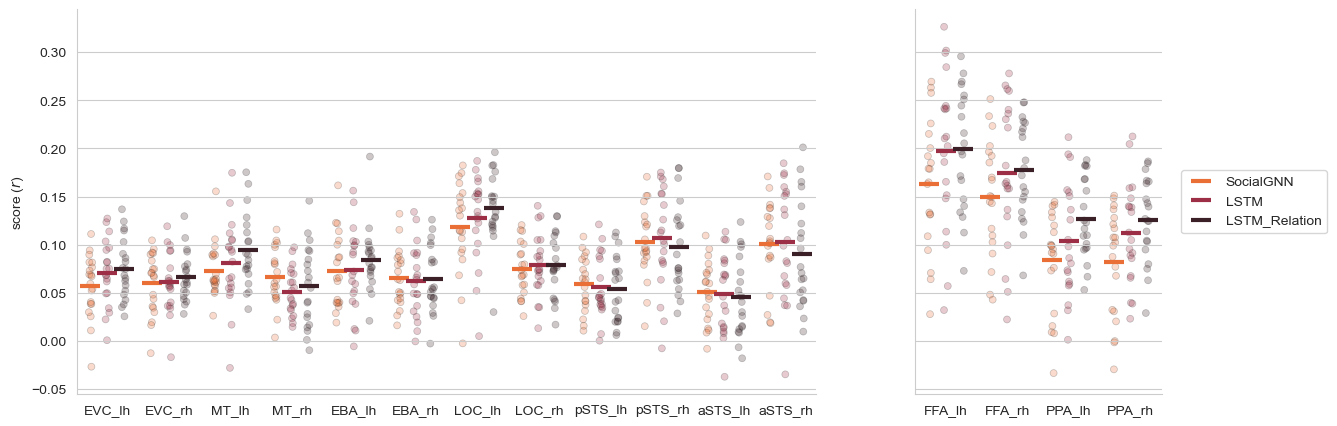

In [38]:
plot_mapping_results(all_scores, 'ROI')

In [ ]:
# import numpy as np
# import nibabel as nib
# from nilearn import plotting
# from nilearn.image import new_img_like
# 
# def create_brain_map_from_roi(best_scores, roi_mask_path, template_img):
#     """
#     Create a brain map by mapping the best scores back to the ROI voxels.
# 
#     Parameters:
#     - best_scores (np.array): 1D array of best scores (e.g., Pearson correlation) for each voxel in the ROI
#     - roi_mask_path (str): Path to the 3D ROI mask file (NIfTI format)
#     - template_img (nib.Nifti1Image): A template brain image for visualization (e.g., a standard brain)
#     
#     Returns:
#     - brain_map (nib.Nifti1Image): A 3D NIfTI image with the scores mapped onto the brain
#     """
#     # Load the 3D ROI mask
#     roi_mask_img = nib.load(roi_mask_path)
#     roi_mask = roi_mask_img.get_fdata().astype(bool)
# 
#     # Create an empty 3D brain map (same shape as the template)
#     brain_map_data = np.zeros(template_img.shape)
# 
#     # Assign the best scores to the voxels inside the ROI
#     brain_map_data[roi_mask] = best_scores
# 
#     # Create a new NIfTI image with the brain map data
#     brain_map_img = new_img_like(template_img, brain_map_data)
# 
#     return brain_map_img
# 
# def visualize_roi_encoding_results(roi_results, roi_mask_paths, template_img):
#     """
#     Visualize the encoding results for each ROI.
# 
#     Parameters:
#     - roi_results (dict): Dictionary containing best scores for each ROI
#     - roi_mask_paths (list of str): List of paths to ROI mask files (NIfTI format)
#     - template_img (nib.Nifti1Image): A template brain image for visualization
#     
#     Returns:
#     - None (displays the visualizations)
#     """
#     for roi_mask_path in roi_mask_paths:
#         # Get the best scores for this ROI
#         best_scores = roi_results[roi_mask_path]['best_scores']
#         
#         # Create a brain map from the ROI results
#         brain_map_img = create_brain_map_from_roi(best_scores, roi_mask_path, template_img)
#         
#         # Visualize the brain map
#         print(f"Visualizing ROI: {roi_mask_path}")
#         plotting.plot_stat_map(brain_map_img, bg_img=template_img, threshold=0.1, display_mode='ortho', title=f'ROI: {roi_mask_path}')
#         plotting.show()
# 
# # Example usage:
# # Assuming you have your results stored in `roi_results`, a list of ROI masks in `roi_mask_paths`,
# # and a template brain image (e.g., MNI152 template) for visualization:
# 
# # Load a template brain image (e.g., MNI152 template from nilearn)
# template_img = nib.load('path_to_template_image.nii.gz')  # Replace with actual path to the template image
# 
# # Visualize the results
# visualize_roi_encoding_results(roi_results, roi_mask_paths, template_img)
